# Basismodell als gemeinsamer Startpunkt für Semesterprojekte (losgelöste Aufgabenstellung ebenfalls möglich)

## Basismodell
Bewertung von Photovoltaik-Anlagen zur Deckung des Eigenbedarfs inkl. Batteriespeicher

In [26]:
# Import necessary libraries
import requests
import pandas as pd
import matplotlib.pyplot as plt
from demandlib import bdew
from geopy.geocoders import Nominatim
import os
import logging
import requests
import pandas as pd
from bs4 import BeautifulSoup
from entsoe import EntsoePandasClient
from datetime import datetime
import configparser
from concurrent.futures import ThreadPoolExecutor

## Annahmen und Optionen

In [27]:
yearly_demand = 3000 # kWh
pv_installed_power = 10 # kWp
selected_location = "Universitätsstraße 12, 45141 Essen"

c_feedin = 0.082 # €/kWh bis 10kWp 8,2 ct/kWh, bis 40kWp 7,1 ct/kWh https://www.bundesnetzagentur.de/DE/Sachgebiete/ElektrizitaetundGas/Unternehmen_Institutionen/ErneuerbareEnergien/ZahlenDatenInformationen/EEG_Registerdaten/start.html
c_pur = 0.35 # €/kWh

P_bat = 10 # kW
E_bat = 20 # kWh
eta_bat = 0.9 # Wirkungsgrad

selected_year = 2019

## Datenbezug und -aufbereitung

### Erzeugung eines Lastprofils
- Standardlastprofil für Haushalte
- Verwendung von demandlib
- Jahresverbrauch in kWh


In [28]:
e_slp = bdew.ElecSlp(selected_year)
elec_demand = e_slp.get_profile({"h0": yearly_demand})

### Erstelle Erzeugungsprofil für PV-Anlage
- Verwendung von pvgis api

In [29]:
# Erstelle Erzeugungsprofil für PV-Anlage

geolocator = Nominatim(user_agent="EuerName")
location = geolocator.geocode(selected_location)


# API-Abfrage
url = "https://re.jrc.ec.europa.eu/api/v5_2/seriescalc"

# Parameter
params = {
    "lat": location.latitude,
    "lon": location.longitude,
    "startyear": selected_year,
    "endyear": selected_year,
    "pvcalculation": 1,
    "peakpower": pv_installed_power,    # kWp
    "loss": 10,
    "outputformat": "json",
}

# Abfrage
r = requests.get(url, params=params)
data = r.json()

# Erstelle DataFrame
elec_pv = pd.DataFrame(data["outputs"]["hourly"])
elec_pv.index = pd.to_datetime(elec_pv["time"], format="%Y%m%d:%H10")
# remove all columns except "P"
elec_pv = elec_pv[["P"]]


In [30]:
# Erstelle ein DataFrame mit dem Lastprofil und dem Erzeugungsprofil
energiesystem = pd.DataFrame()
energiesystem["demand"] = elec_demand
energiesystem["pv"] = elec_pv["P"] / 1000 # kW

# Konvertiere in stündliche Werte
energiesystem = energiesystem.resample("h").mean()

# summe von demand und pv, gerundet ohne Kommastellen
print(f"Summe des Lastprofils: {energiesystem['demand'].sum():.0f}")
print(f"Summe des PV-Erzeugungsprofils: {energiesystem['pv'].sum():.0f}")


Summe des Lastprofils: 3000
Summe des PV-Erzeugungsprofils: 9152


In [20]:
energiesystem.to_csv("Energiesystem.csv")

Text(0.5, 1.0, 'Woche 23')

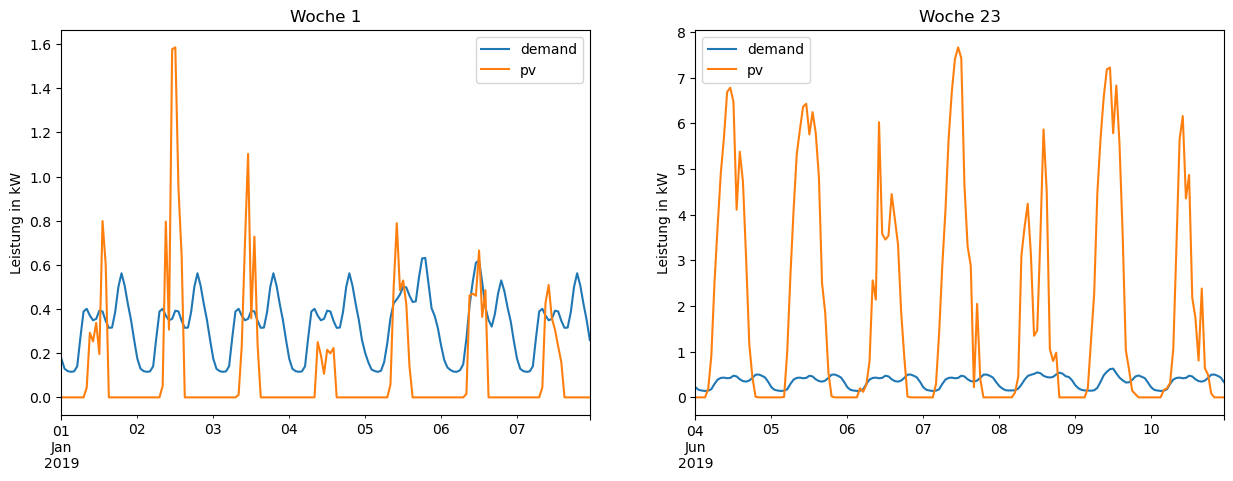

In [21]:
# Plotte das Lastprofil und das Erzeugungsprofil für zwei ausgewählte Wochen in subplots nebeneinander
week_no_left = 1
week_no_right = 23

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
energiesystem[(week_no_left-1)*24*7:week_no_left*24*7].plot(ax=ax1)
ax1.set_ylabel("Leistung in kW")
ax1.set_title("Woche " + str(week_no_left))

energiesystem[(week_no_right-1)*24*7:week_no_right*24*7].plot(ax=ax2)
ax2.set_ylabel("Leistung in kW")
ax2.set_title("Woche " + str(week_no_right))

# Berechnung der Eigenverbrauchsquote, Autarkiequote und Wirtschaftlichkeit



In [22]:
# Berechne den Eigenverbrauch
energiesystem["feedin"] = energiesystem["pv"] - energiesystem["demand"]
energiesystem["feedin"] = energiesystem["feedin"].clip(lower=0)

energiesystem["self_consumption"] = energiesystem["pv"] - energiesystem["feedin"]

energiesystem["electricity_purchase"] = energiesystem["demand"] - energiesystem["self_consumption"]

energiesystem.index.name = 't'

# Gib die Eigenverbrauchsquote aus
eigenverbrauchsquote = energiesystem["self_consumption"].sum() / energiesystem["pv"].sum() * 100
print(f"Eigenverbrauchsquote: {eigenverbrauchsquote:.0f} %")

# Gib die Autarkiequote aus
autharkiegrad = energiesystem["self_consumption"].sum() / energiesystem["demand"].sum() * 100
print(f"Autarkiegrad: {autharkiegrad:.0f} %")



Eigenverbrauchsquote: 16 %
Autarkiegrad: 49 %


In [23]:
print(elec_pv)

                       P
time                    
2019-01-01 00:00:00  0.0
2019-01-01 01:00:00  0.0
2019-01-01 02:00:00  0.0
2019-01-01 03:00:00  0.0
2019-01-01 04:00:00  0.0
...                  ...
2019-12-31 19:00:00  0.0
2019-12-31 20:00:00  0.0
2019-12-31 21:00:00  0.0
2019-12-31 22:00:00  0.0
2019-12-31 23:00:00  0.0

[8760 rows x 1 columns]


# Aufstellung eines Optimierungsproblems

## Zielfunktion
- Minimierung der Kosten abzüglich der Einspeisevergütung
- Strombezug aus dem Netz $y^{pur}_t$
- Einspeisung in das Netz $y^{pv,feedin}_t$
- Einspeisevergütung $c^{feedin}$
- Bezugskosten $c^{pur}$
$$ \min \sum_{t=1}^{T} (y^{pur}_t \cdot c^{pur} \cdot {dt} - y^{pv,feedin}_t \cdot c^{feedin} \cdot {dt}) $$

## Nebenbedingungen
- Deckung der Nachfrage $D_t$ aus Netzbezug $y^{pur}_t$, PV Eigennutzung, $y^{pv,self}_t$ und Entladung Batterie $y^{s,dc}_t$
$$ y^{pur}_t + y^{pv,self}_t + y^{s,dc}_t - y^{s,ch}_t = D_t $$
- Aufteilung der gesamten PV-Erzeugung ${PV}_t$ in Eigennutzung $y^{pv,self}_t$ und Einspeisung $y^{pv,feedin}_t$
$$ y^{pv,self}_t + y^{pv,feedin}_t = {PV}_t $$

- Speicherfüllstandsrestriktionen (Speicherfüllstand $l^s_t$) mit Batteriekapazität $E^{bat}$, Lade-/Entladeleistung $P^{bat}$ und Wirkungsgrad $\eta_{bat}$
$$ y^{s,dc}_t <= P^{bat} $$
$$ y^{s,ch}_t <= P^{bat} $$
$$ l^s_t + y^{s,ch}_t \cdot \eta_{bat} \cdot {dt} - y^{s,dc}_t \cdot {dt} - l^s_{t+1}= 0 $$
$$ 0 <= l^s_t <= E^{bat} $$




## Zielfunktion
- Minimierung der Gesamtkosten:
  - Wärmepumpenkosten \( c_t \cdot P_t \)
  - Strombezugskosten \( y^{pur}_t \cdot c^{pur} \cdot dt \)
  - Abzüglich Einspeisevergütung \( y^{pv,feedin}_t \cdot c^{feedin} \cdot dt \)

$$
\min \sum_{t=1}^{T} \left( c_t \cdot P_t + y^{pur}_t \cdot c^{pur} \cdot dt - y^{pv,feedin}_t \cdot c^{feedin} \cdot dt \right)
$$

## Nebenbedingungen

### 1. Wärmepumpe und Wärmespeicher
- **Grenzen der Wärmeerzeugung:**

$$
0 \leq P_t \leq P_{\text{max}}, \quad \forall t \in \{1, \dots, T\}
$$

- **Grenzen für Speicherein- und -ausspeicherung:**

$$
0 \leq x^{\text{in}}_t \leq X_{\text{in,max}}, \quad 0 \leq x^{\text{out}}_t \leq X_{\text{out,max}}, \quad \forall t \in \{1, \dots, T\}
$$

- **Grenzen für den Wärmespeicherfüllstand:**

$$
0 \leq B_t \leq B_{\text{max}}, \quad \forall t \in \{1, \dots, T\}
$$

- **Wärmebilanz:**

$$
P_t + x^{\text{out}}_t = d_t + x^{\text{in}}_t, \quad \forall t \in \{1, \dots, T\}
$$

- **Dynamik des Speicherfüllstands:**

$$
B_{t+1} = B_t + x^{\text{in}}_t - x^{\text{out}}_t, \quad \forall t \in \{1, \dots, T-1\}
$$

$$
B_1 = B_{\text{start}} + x^{\text{in}}_1 - x^{\text{out}}_1
$$

### 2. Stromsystem (Netz, PV, Batteriespeicher)
- **Deckung der elektrischen Nachfrage:**

$$
y^{pur}_t + y^{pv,self}_t + y^{s,dc}_t - y^{s,ch}_t = D_t, \quad \forall t \in \{1, \dots, T\}
$$

- **Aufteilung der PV-Erzeugung:**

$$
y^{pv,self}_t + y^{pv,feedin}_t = PV_t, \quad \forall t \in \{1, \dots, T\}
$$

- **Grenzen für Batterie-Lade- und Entladeleistung:**

$$
y^{s,dc}_t \leq P^{bat}, \quad y^{s,ch}_t \leq P^{bat}, \quad \forall t \in \{1, \dots, T\}
$$

- **Dynamik des Batterie-Füllstands:**

$$
l^s_{t+1} = l^s_t + y^{s,ch}_t \cdot \eta_{bat} \cdot dt - y^{s,dc}_t \cdot dt, \quad \forall t \in \{1, \dots, T-1\}
$$

- **Grenzen des Batterie-Füllstands:**

$$
0 \leq l^s_t \leq E^{bat}, \quad \forall t \in \{1, \dots, T\}
$$

- **Elektrischer Betrieb der Wärmepumpe:**

$$
D_t = D_t^{\text{Haushalt}} + \frac{P_t}{\mathrm{COP}}, \quad \forall t \in \{1, \dots, T\}
$$

## Zusammenfassung der Entscheidungsvariablen
- Wärmepumpenkosten \( c_t \cdot P_t \)
- Strombezug aus dem Netz \( y^{pur}_t \)
- Einspeisung ins Netz \( y^{pv,feedin}_t \)
- PV-Eigennutzung \( y^{pv,self}_t \)
- Entladung der Batterie \( y^{s,dc}_t \)
- Ladung der Batterie \( y^{s,ch}_t \)
- Speicherfüllstand Wärmespeicher \( B_t \)
- Batterie-Füllstand \( l^s_t \)
- Speicherein \( x^{\text{in}}_t \)
- Speicheraus \( x^{\text{out}}_t \)

## Parameter
- Kosten pro kW Wärme \( c_t \)
- Konstanter Strombezugspreis \( c^{pur} \) (EUR/kWh)
- Einspeisevergütung \( c^{feedin} \) (EUR/kWh)
- Zeitschrittlänge \( dt \) (z.B. 1 Stunde)
- Maximale Leistung der Wärmepumpe \( P_{\text{max}} \)
- Maximale Einspeicherleistung \( X^{\text{in,max}} \)
- Maximale Ausspeicherleistung \( X^{\text{out,max}} \)
- Maximale Speicherkapazität Wärmespeicher \( B_{\text{max}} \)
- Anfangsfüllstand Wärmespeicher \( B_{\text{start}} \)
- PV-Erzeugung \( PV_t \) in Stunde \( t \)
- Elektrische Nachfrage \( D_t \) in Stunde \( t \) (inklusive Wärmepumpe)
- Batteriekapazität \( E^{bat} \)
- Maximale Lade-/Entladeleistung der Batterie \( P^{bat} \)
- Batteriewirkungsgrad \( \eta_{bat} \)
- Leistungszahl der Wärmepumpe \( \mathrm{COP} \)

---


In [24]:
# Vorbereitung des Optimierungsmodells

t = pd.Index(energiesystem.index, name='t')
dt = (t[1] - t[0]).total_seconds() / 3600  # time step width in hours

D_t = energiesystem["demand"].to_xarray()
PV_t = energiesystem["pv"].to_xarray()



In [25]:
# Erstellung eines Optimierungsmodells



# Erstelle ein Modell
m = Model()

# Erstelle die Variablen
y_pur_t = m.add_variables(coords=[t], name="y_pur_t",lower=0)
y_pv_feedin_t = m.add_variables(coords=[t], name="y_pv_feedin_t",lower=0)
y_pv_self_t = m.add_variables(coords=[t], name="y_pv_self_t",lower=0)
y_s_ch_t = m.add_variables(coords=[t], name="y_s_ch_t",lower=0)
y_s_dc_t = m.add_variables(coords=[t], name="y_s_dc_t",lower=0)
l_s_t = m.add_variables(coords=[t], name="l_s_t",lower=0)

# Erstelle die Nebenbedingungen
m.add_constraints(y_pur_t + y_pv_self_t + y_s_dc_t - y_s_ch_t == D_t, name="demand")
m.add_constraints(y_pv_feedin_t + y_pv_self_t == PV_t, name="pv")
m.add_constraints(l_s_t + y_s_ch_t * eta_bat * dt - y_s_dc_t * dt - l_s_t.roll(t=-1) == 0, name="filling_level")
m.add_constraints(l_s_t <= E_bat, name="capacity")
m.add_constraints(y_s_ch_t <= P_bat, name="charging_power")
m.add_constraints(y_s_dc_t <= P_bat, name="discharging_power")

# Erstelle die Zielfunktion
m.add_objective(c_pur * y_pur_t.sum() - c_feedin * y_pv_feedin_t.sum())

# Löse das Modell
m.solve(solver="highs")

# Gib die Ergebnisse aus
solution = m.solution.to_dataframe()

solution.to_clipboard(decimal=",")


NameError: name 'Model' is not defined